In [9]:
!pip install rouge

import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from rouge import Rouge

# Preprocessing

In [10]:
train_data = pd.read_csv('../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
test_data = pd.read_csv('../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [11]:
train_data = train_data.drop(['id'], axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.drop(['id'], axis=1)
test_data = test_data.reset_index(drop=True)

In [12]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [13]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
        
    return text

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in train_data.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')
    
clean_texts = []
for text in train_data.article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
del train_data

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cleaning Summaries Complete
Cleaning Texts Complete


In [15]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:110000]
clean_df['summary'] = clean_summaries[:110000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_texts
del clean_summaries

# Tokenizing Text And Summary Data

In [16]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

In [18]:
import pickle

In [19]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

with open("t_tokenizer.pkl", "wb") as f:
    pickle.dump(t_tokenizer, f)
print("✅ Saved t_tokenizer.pkl")

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

✅ Saved t_tokenizer.pkl


In [20]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  60.00719413677853
Total Coverage of rare words:  0.7458147584629847
Text Vocab:  133418


In [21]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

import pickle
with open("s_tokenizer.pkl", "wb") as f:
    pickle.dump(s_tokenizer, f)
print("✅ Saved s_tokenizer.pkl")

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

✅ Saved s_tokenizer.pkl


In [22]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  70.11489659306625
Total Coverage of rare words:  2.4837378859339996
Summary Vocab:  29912


In [23]:
maxlen_text = 800
maxlen_summ = 150

In [24]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))

In [25]:
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [26]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [27]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (99000, 800)
Target Values Shape (99000, 150)
Test Sequence (11000, 800)
Target Test Shape (11000, 150)


# Pretrained Embedding

In [28]:
import numpy as np
from datasets import load_dataset

# Load the GloVe file as a text dataset
ds = load_dataset("SLU-CSCI4750/glove.6B.100d.txt", split="train")

# Build the embedding index
embedding_index = {}
for example in ds:
    line = example["text"]
    values = line.strip().split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs

# Example lookup
print("vector for 'the' has shape:", embedding_index["the"].shape)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/SLU-CSCI4750--glove.6B.100d.txt-c124a31aa39fe5d0/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.
vector for 'the' has shape: (100,)


In [29]:
embeding_index = {}
embed_dim = 100


In [30]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [31]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [32]:
del embeding_index

# Model Architecture

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 800, 100)     13341800    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 256), (None, 234496      embedding_4[0][0]                
____________________________________________________________________________________________

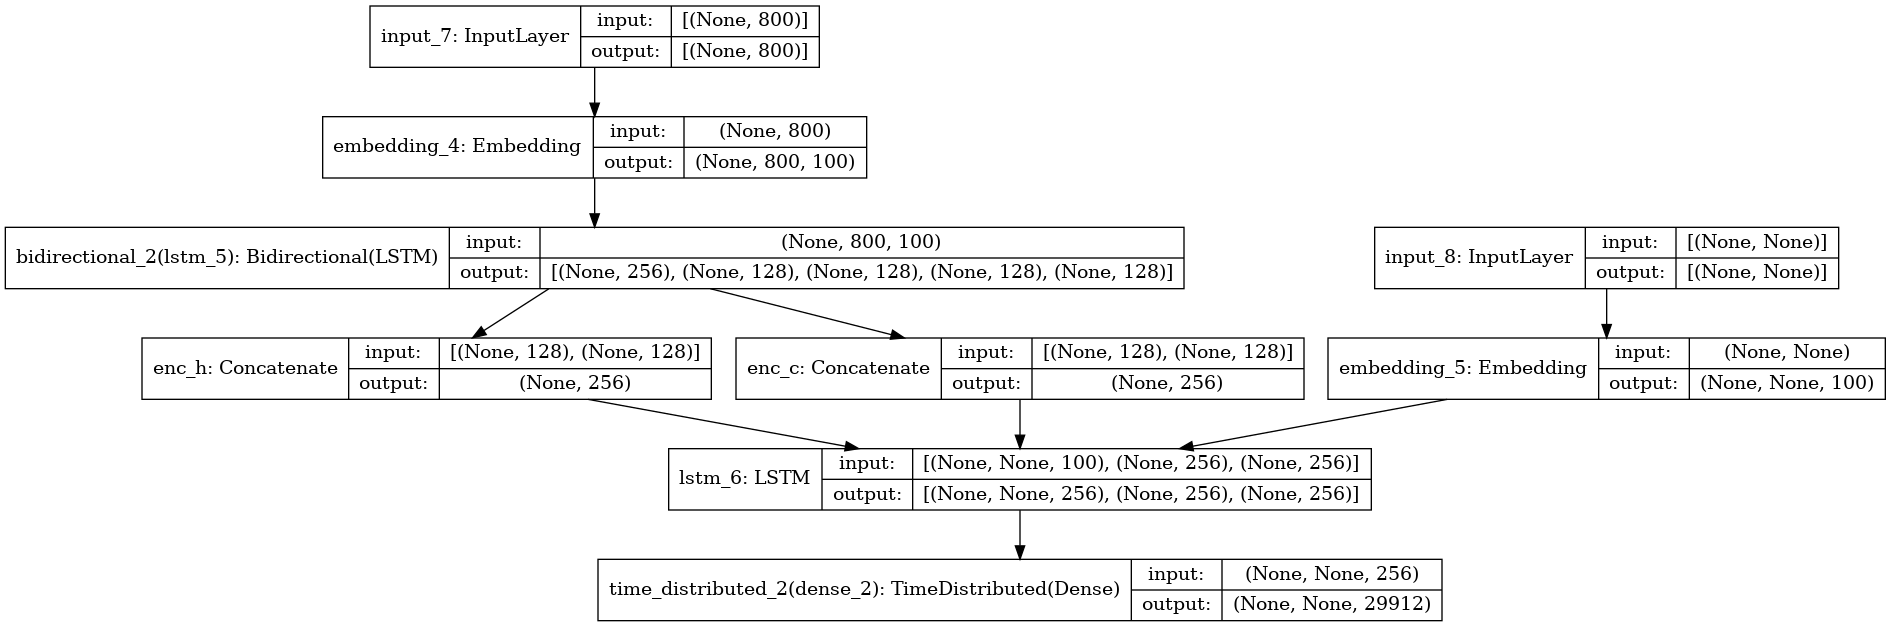

In [44]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
#h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
#h_out, _, _ = h_lstm(enc_embed)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [34]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=10, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/10
774/774 - 670s - loss: 2.7841 - val_loss: 2.6994
Epoch 2/10
774/774 - 660s - loss: 2.6971 - val_loss: 2.6896
Epoch 3/10
774/774 - 659s - loss: 2.6935 - val_loss: 2.6894
Epoch 4/10
774/774 - 659s - loss: 2.6920 - val_loss: 2.6887
Epoch 5/10
774/774 - 658s - loss: 2.6910 - val_loss: 2.6888
Epoch 6/10
774/774 - 659s - loss: 2.6904 - val_loss: 2.6895
Epoch 00006: early stopping


# Inference

In [35]:
with open("model_arch.json", "w") as f:
    f.write(model.to_json())

In [36]:
# 2) Save weights
model.save_weights("model_weights.h5")

In [37]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [38]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq

In [39]:
test_inputs = [clean_text(sent) for sent in test_data.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [40]:
hyps = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(500):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.article[i], test_data.highlights[i], our_summ])

# ROUGE score

In [41]:
rouge = Rouge()
rouge.get_scores(hyps, test_data.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.0721313821161702,
  'p': 0.6036000000000007,
  'f': 0.1275953445310741},
 'rouge-2': {'r': 0.0038021637158546545,
  'p': 0.023,
  'f': 0.006423252029786479},
 'rouge-l': {'r': 0.06791594756007224,
  'p': 0.5708000000000006,
  'f': 0.12023245840591956}}

# Saving the Model


In [42]:
import pickle
model.save("video_summarizer.h5")               


print("Model saved to video_summarizer.h5 and tokenizer to tokenizer.pkl")

Model saved to video_summarizer.h5 and tokenizer to tokenizer.pkl


# Load the Model and Tokenizer

In [32]:
loaded_model = tf.keras.models.load_model("video_summarizer.h5")

# Load tokenizer
with open("s_tokenizer.pkl", "rb") as f:
    s_tokenizer = pickle.load(f)

In [33]:
# Load tokenizer
with open("t_tokenizer.pkl", "rb") as f:
    t_tokenizer = pickle.load(f)

# Test

In [ ]:
import re
import numpy as np
import pickle
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

# 1) Load the trained seq2seq model
#    (you saved it with model.save("video_summarizer.h5"))
model = load_model("video_summarizer.h5", compile=False)

# 2) Load your two tokenizers
with open("s_tokenizer.pkl", "rb") as f:
    s_tokenizer = pickle.load(f)
with open("t_tokenizer.pkl", "rb") as f:
    t_tokenizer = pickle.load(f)

# 3) Extract constants (must match your training run)
maxlen_text    = 800
maxlen_summ    = 150
latent_dim     = 128

# Reverse‐index for decoding
index_to_word = {i: w for w, i in s_tokenizer.word_index.items()}

# 4) Rebuild inference sub‐models

# Encoder sub‐model
enc_input = model.input[0]
enc_embed = model.get_layer("embedding")(enc_input)
bid_lstm   = model.get_layer("bidirectional")
enc_out, fh, fc, bh, bc = bid_lstm(enc_embed)
enc_h = Concatenate(name="enc_h")([fh, bh])
enc_c = Concatenate(name="enc_c")([fc, bc])
enc_model = Model(enc_input, [enc_h, enc_c])

# Decoder sub‐model
dec_input     = model.input[1]
dec_state_h   = Input(shape=(latent_dim*2,), name="dec_state_h")
dec_state_c   = Input(shape=(latent_dim*2,), name="dec_state_c")
dec_embed     = model.get_layer("embedding_1")(dec_input)
dec_lstm_l    = model.get_layer("lstm_1")
dec_outs, dh, dc = dec_lstm_l(dec_embed, initial_state=[dec_state_h, dec_state_c])
dec_dense     = model.get_layer("time_distributed")
dec_outputs   = dec_dense(dec_outs)
dec_model = Model(
    [dec_input, dec_state_h, dec_state_c],
    [dec_outputs, dh, dc]
)

# 5) Re-use your clean_text from training (fixed regex)
contractions = {
  # … your contractions dict …
}
def clean_text(text, remove_stopwords=True):
    words = text.lower().split()
    words = [contractions.get(w, w) for w in words]
    text = " ".join(words)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r'[_"\;%()|+&=*%.,!?:#$@\[\]/-]', " ", text)
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\'", " ", text)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = " ".join(w for w in text.split() if w not in stops)
    return text

# 6) Greedy‐decode function
def generate_summary(raw_text):
    # a) Clean & tokenize the input
    clean = clean_text(raw_text)
    seq   = t_tokenizer.texts_to_sequences([clean])
    enc_seq = pad_sequences(seq, maxlen=maxlen_text, padding="post")

    # b) Encode to get initial states
    h, c = enc_model.predict(enc_seq, verbose=0)

    # c) Iterate one token at a time
    start_i = s_tokenizer.word_index["sostok"]
    end_i   = s_tokenizer.word_index["eostok"]
    target_seq = np.array([[start_i]])
    decoded    = []

    for _ in range(maxlen_summ):
        out_probs, h, c = dec_model.predict([target_seq, h, c], verbose=0)
        sampled_i = np.argmax(out_probs[0, -1, :])
        if sampled_i == end_i:
            break
        word = index_to_word.get(sampled_i, "")
        if word:
            decoded.append(word)
        target_seq = np.array([[sampled_i]])

    return " ".join(decoded)

# 7) Example usage
if __name__ == "__main__":
    article = (
        "Earlier this week, environmental scientists published a new study "
        "on the rapid decline of urban bee populations, attributing the trend "
        "to habitat loss and widespread pesticide use. Data showed a 45% drop..."
    )
    print("Generated Summary:", generate_summary(article))
